In [1]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook', style='whitegrid', rc={'figure.figsize': (8, 8)})

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

### Data ingestion & cleaning

In [2]:
# Read in ocean data
ocean_data = pd.read_csv('data/ocean_data.csv')
ocean_data.head()

lat_dd  lon_dd    z_m  flux_molC_m2_yr  temp  oxy  rho  visc  dic  po4  \
0   -89.5  -179.5  100.0              NaN   NaN  NaN  NaN   NaN  NaN  NaN   
1   -89.5  -179.5  125.0              NaN   NaN  NaN  NaN   NaN  NaN  NaN   
2   -89.5  -179.5  150.0              NaN   NaN  NaN  NaN   NaN  NaN  NaN   
3   -89.5  -179.5  200.0              NaN   NaN  NaN  NaN   NaN  NaN  NaN   
4   -89.5  -179.5  250.0              NaN   NaN  NaN  NaN   NaN  NaN  NaN   

   dsi  omega  
0  NaN    NaN  
1  NaN    NaN  
2  NaN    NaN  
3  NaN    NaN  
4  NaN    NaN

In [3]:
geo_coords_name = ['lat_dd', 'lon_dd'] # geographic coordinates
dep_coord_name = 'z_m' # depth coordinate
target_name = 'flux_molC_m2_yr' # target variable
feat_names = ocean_data.columns.drop([*geo_coords_name, dep_coord_name, target_name]).to_list() # features

In [4]:
ocean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749600 entries, 0 to 1749599
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   lat_dd           float64
 1   lon_dd           float64
 2   z_m              float64
 3   flux_molC_m2_yr  float64
 4   temp             float64
 5   oxy              float64
 6   rho              float64
 7   visc             float64
 8   dic              float64
 9   po4              float64
 10  dsi              float64
 11  omega            float64
dtypes: float64(12)
memory usage: 160.2 MB


In [5]:
print(f'Number of rows & columns in dataset: {ocean_data.shape}')
print(ocean_data.isna().sum(axis='rows'))

Number of rows & columns in dataset: (1749600, 12)
lat_dd                  0
lon_dd                  0
z_m                     0
flux_molC_m2_yr    899411
temp               868168
oxy                868168
rho                868168
visc               868168
dic                887360
po4                899240
dsi                902986
omega              893881
dtype: int64


In [6]:
# Drop rows where all values are missing
ocean_data = ocean_data.dropna(axis='index', how='all')
print(f'Number of samples in dataset: {len(ocean_data)}')

Number of samples in dataset: 1749600


In [7]:
# Drop rows where target variable is missing
ocean_data = ocean_data[~ocean_data[target_name].isna()]
print(f'Number of samples in dataset: {len(ocean_data)}')

Number of samples in dataset: 850189


In [8]:
# Drop rows where all feature values are missing
ocean_data = ocean_data.dropna(axis='index', how='all', subset=feat_names)
print(f'Number of samples in dataset: {len(ocean_data)}')

Number of samples in dataset: 850189


In [9]:
# Keep only rows with at least 50% non-NaN feature values
ocean_data = ocean_data.dropna(axis='index', thresh=int(np.floor(len(feat_names)/2)), subset=feat_names)
print(f'Number of samples in dataset: {len(ocean_data)}')

Number of samples in dataset: 850189


### Exploratory data analysis

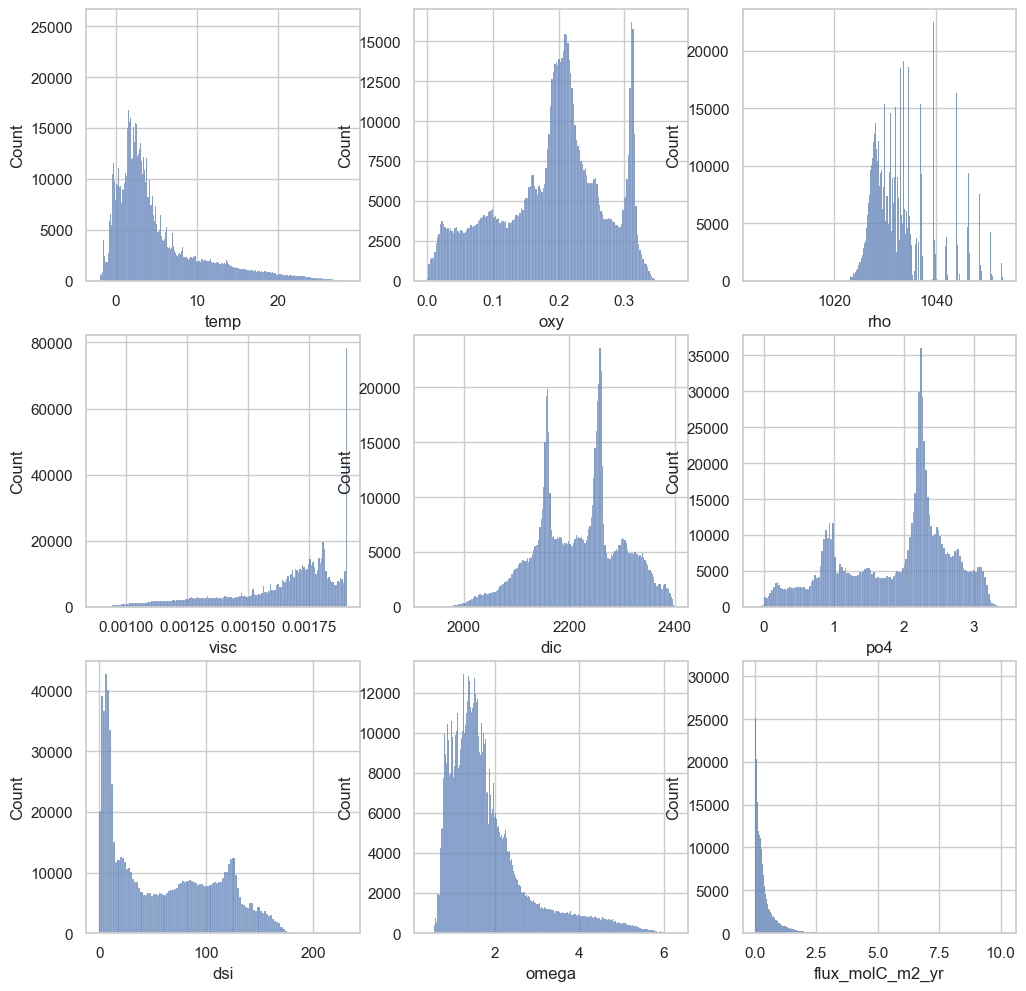

In [10]:
# Plot histograms to show distributions of variables
nvars = len(feat_names) + 1
nrows, ncols = int(np.ceil(nvars/3)), 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
for ax, var_name in zip(axs.reshape(-1), [*feat_names, target_name]):
    sns.histplot(data=ocean_data, x=var_name, ax=ax);

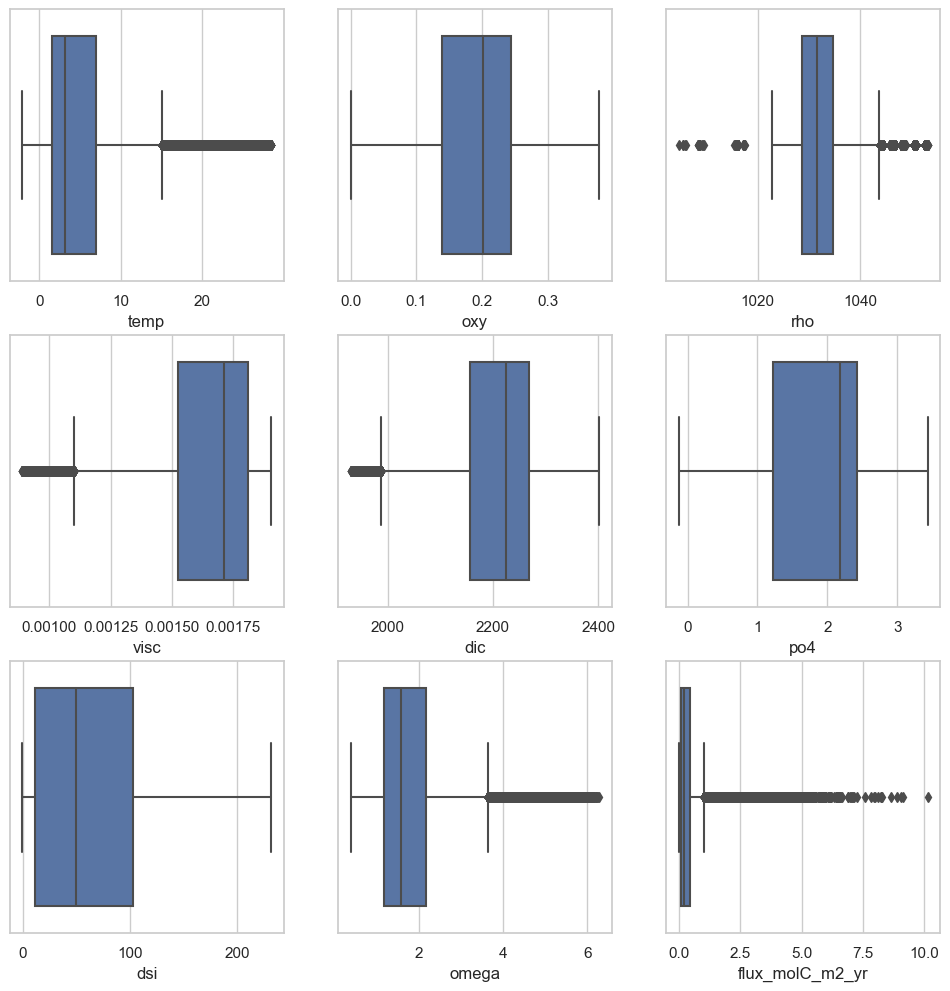

In [11]:
# Plot box plots to visualize possible outliers
nvars = len(feat_names) + 1
nrows, ncols = int(np.ceil(nvars/3)), 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
for ax, var_name in zip(axs.reshape(-1), [*feat_names, target_name]):
    sns.boxplot(data=ocean_data, x=var_name, ax=ax);

In [12]:
# Plot box plots to show distributions of target variable by latitude and depth bins
def make_bin_labels(bin_list):
    bin_labels = [str(bin) for bin in bin_list]
    bin_labels = [' - '.join([bin_labels[ibin], bin_labels[ibin+1]]) for ibin in range(len(bin_labels)-1)]
    return bin_labels

lat_bins = np.around(np.linspace(ocean_data['lat_dd'].min(), ocean_data['lat_dd'].max(), 10), 1).tolist()
lat_labels = make_bin_labels(lat_bins)
ocean_data['lat_bins'] = pd.cut(ocean_data['lat_dd'], bins=lat_bins, labels=lat_labels, right=True, include_lowest=True)

z_bins = [100, 112.5, 125, 150, 200, 300, 500, 1_000, 2_000, 5_500]
z_labels = make_bin_labels(z_bins)
ocean_data['dep_bins'] = pd.cut(ocean_data[dep_coord_name], bins=z_bins, labels=z_labels, right=True, include_lowest=True)

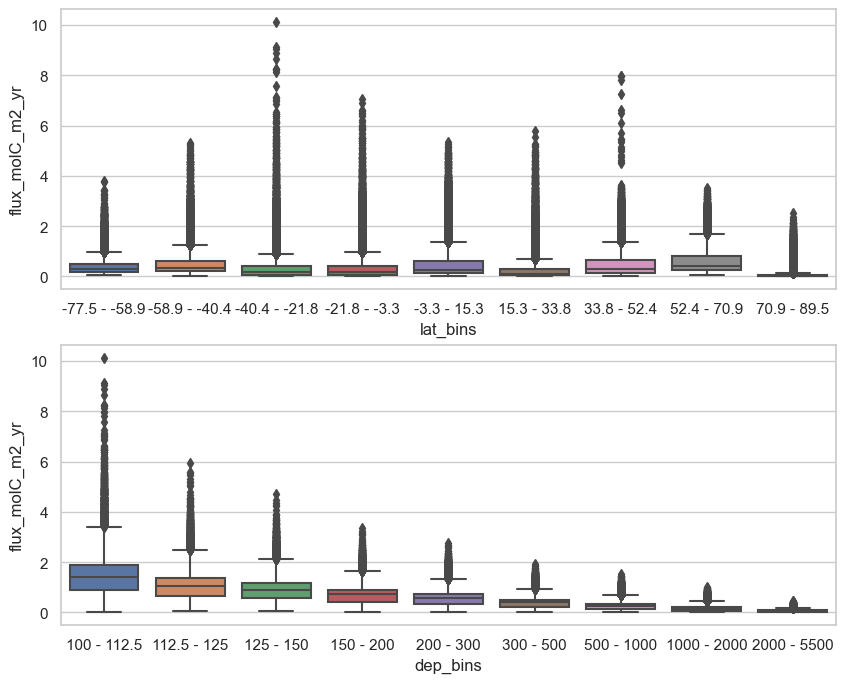

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.boxplot(data=ocean_data, x='lat_bins', y=target_name, ax=ax1);
sns.boxplot(data=ocean_data, x='dep_bins', y=target_name, ax=ax2);

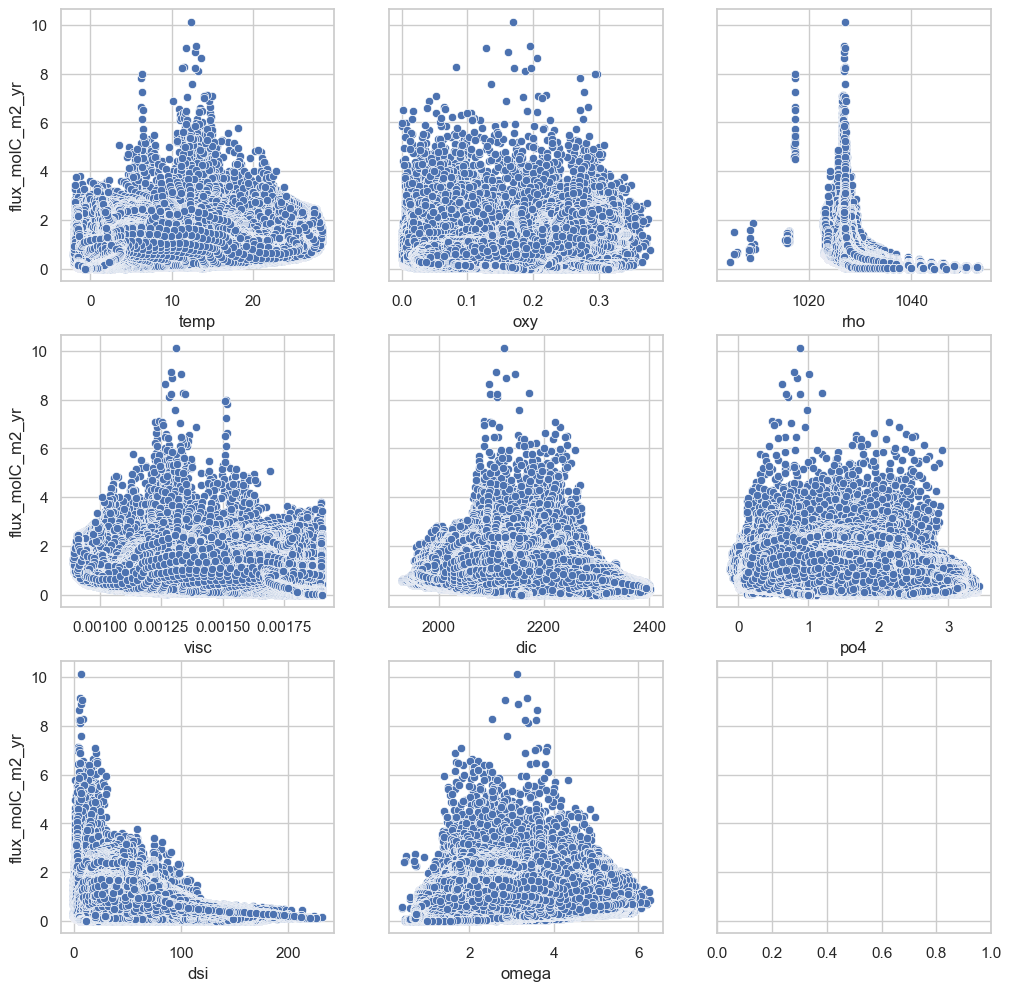

In [14]:
# Plot pairwise relationships in dataset
#sns.pairplot(ocean_data, x_vars=feat_names, y_vars=target_name);
nvars = len(feat_names)
nrows, ncols = int(np.ceil(nvars/3)), 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(12, 12))
for ax, var_name in zip(axs.reshape(-1), feat_names):
    sns.scatterplot(data=ocean_data, x=var_name, y=target_name, ax=ax);

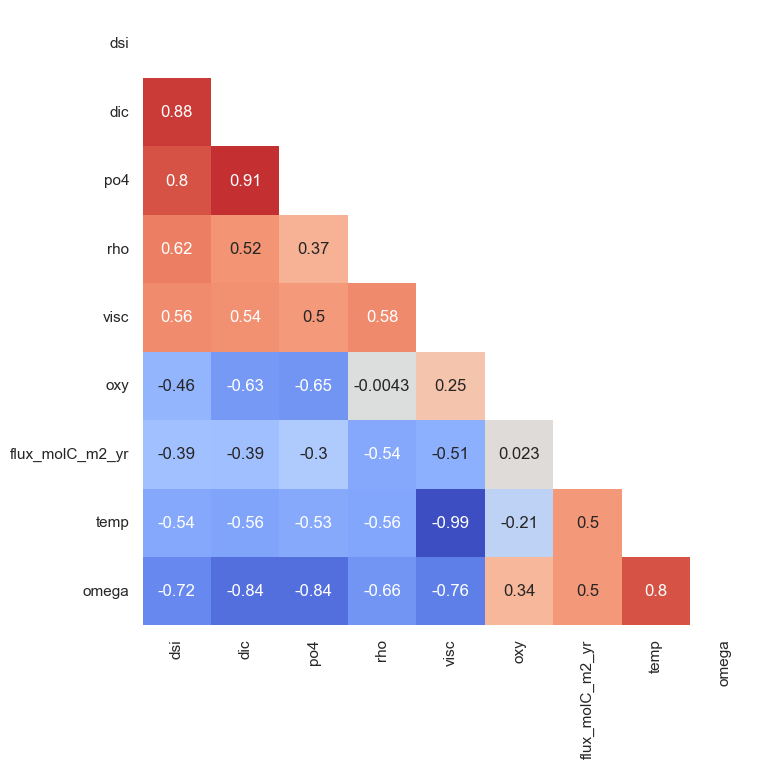

In [15]:
# Compute pairwise correlation of variables,
# and plot correlation matrix as heatmap
corr = ocean_data[[*feat_names, target_name]].corr(method='pearson')
corr_order = np.array(hierarchy.dendrogram(hierarchy.ward(corr), no_plot=True)['ivl'], dtype='int')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    sns.heatmap(corr.iloc[corr_order, corr_order], vmin=-1, vmax=1, cmap='coolwarm', annot=True,
                square=True, mask=mask, cbar=False)

In [16]:
# Plot two components extracted by PCA to better visualize structure in data
pca_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler(),
                         PCA(n_components=2))
data_reduced = pca_pipe.fit_transform(ocean_data[feat_names])
data_reduced = pd.DataFrame(data=np.hstack([data_reduced, ocean_data[target_name].values.reshape(-1,1)]),
                            columns=['PC1', 'PC2', 'target'])

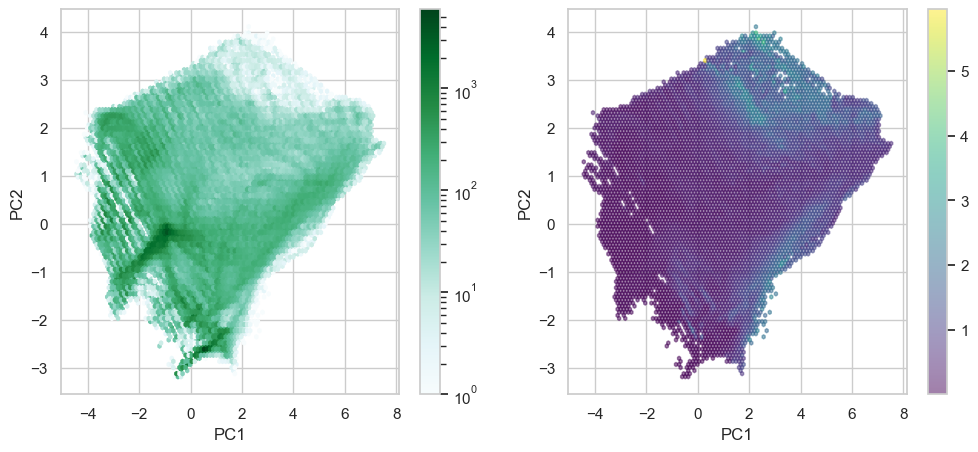

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
data_reduced.plot.hexbin(x='PC1', y='PC2', bins='log', ax=ax1);
data_reduced.plot.hexbin(x='PC1', y='PC2', C='target', reduce_C_function=np.mean,
                         cmap='viridis', alpha=0.5, ax=ax2);

### ML workflow

In [18]:
# Set aside unique geographic coordinates
coords_xy = ocean_data.copy()[geo_coords_name].drop_duplicates()

In [19]:
# Generate spatial features
ocean_data['m_to_seasurf'] = ocean_data[dep_coord_name] - 0
feat_names.append('m_to_seasurf')
ocean_data['dd_to_eq'] = np.abs(ocean_data['lat_dd'] - 0)
feat_names.append('dd_to_eq')

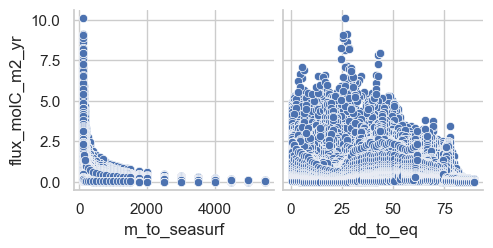

In [20]:
sns.pairplot(ocean_data, x_vars=['m_to_seasurf', 'dd_to_eq'], y_vars=target_name);

In [21]:
# Create spatial clusters based on geographic coordinates using k-means clustering,
# which will be used to split data into folds during cross-validation
num_blocks = 8
block_data = coords_xy.copy()
spat_clusters = KMeans(n_clusters=num_blocks, n_init=50).fit_predict(block_data)
block_data['block'] = spat_clusters

In [22]:
len_data = len(ocean_data)
ocean_data = ocean_data.merge(block_data, how='inner', on=geo_coords_name)
assert len_data == len(ocean_data), f'Size of dataset has changed following merge operation'

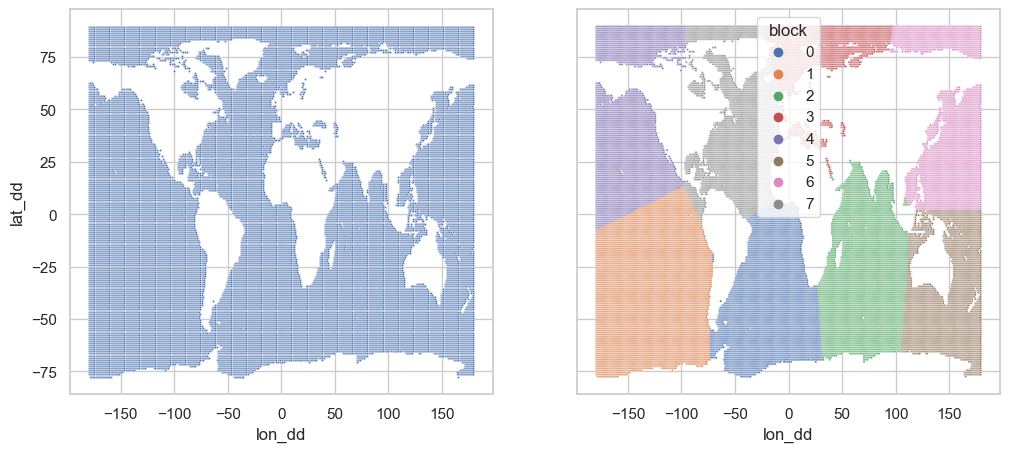

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
sns.scatterplot(data=ocean_data.drop_duplicates(subset=geo_coords_name),
                x='lon_dd', y='lat_dd', marker='.', s=10, ax=ax1);
sns.scatterplot(data=ocean_data.drop_duplicates(subset=geo_coords_name),
                x='lon_dd', y='lat_dd', hue='block', palette='deep', marker='.', s=10, ax=ax2);

In [24]:
# Given large size of dataset, draw random subsample to iterate more quickly
subsample_data = False
if subsample_data:
    ocean_data = ocean_data.sample(n=10_000, replace=False, random_state=2023)

In [25]:
# Split dataset into random train and test subsets,
# such that the same (lat, lon) coordinate pair does not appear in both training and test sets
test_size = 0.2
coords_xy_shuffled = coords_xy.sample(frac=1, replace=False, random_state=2023)
coords_xy_test = coords_xy_shuffled.sample(frac=test_size, replace=False, random_state=2023)
coords_xy_train = coords_xy_shuffled[~coords_xy_shuffled.set_index(geo_coords_name).index.isin(
    coords_xy_test.set_index(geo_coords_name).index)]
train = ocean_data.merge(coords_xy_train, how='inner', on=geo_coords_name)
test = ocean_data.merge(coords_xy_test, how='inner', on=geo_coords_name)
assert len(train) + len(test) == len(ocean_data), f'Size of train+test subsets does not equal size of dataset'

In [26]:
X_train, X_test, y_train, y_test = train[feat_names], test[feat_names], train[target_name], test[target_name]
blocks_train = train['block'] # spatial blocks for k-fold cross-validation
# Copy train and test subsets to avoid SettingWithCopyWarning in pandas
X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
print(f'Number of samples in training set: {len(X_train)}')
print(f'Number of samples in test set: {len(X_test)}')
print(f'Features ({len(feat_names)}): {feat_names}')

Number of samples in training set: 679885
Number of samples in test set: 170304
Features (10): ['temp', 'oxy', 'rho', 'visc', 'dic', 'po4', 'dsi', 'omega', 'm_to_seasurf', 'dd_to_eq']


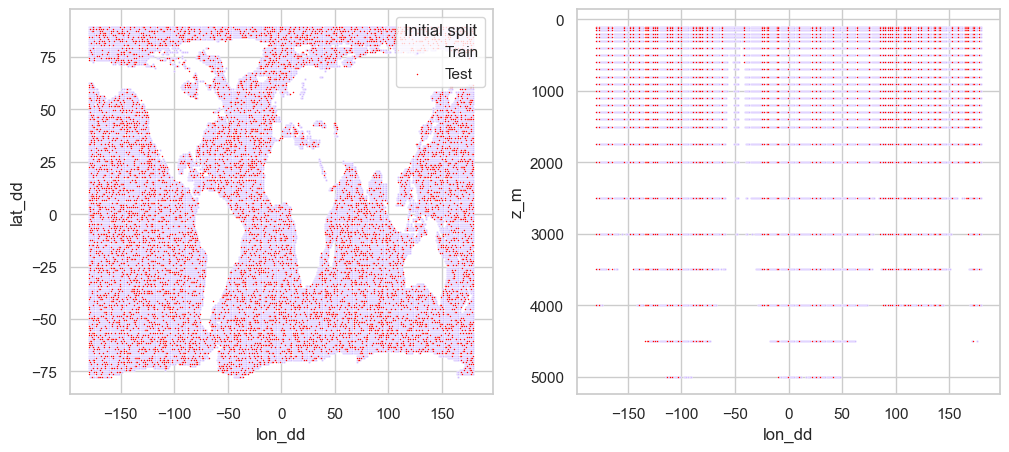

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.scatterplot(data=train.drop_duplicates(subset=geo_coords_name),
                x='lon_dd', y='lat_dd', color='#d0bbff', marker='.', s=10, label='Train', ax=ax1);
sns.scatterplot(data=test.drop_duplicates(subset=geo_coords_name),
                x='lon_dd', y='lat_dd', color='red', marker='.', s=5, label='Test', ax=ax1);
ax1.legend(title='Initial split');
sns.scatterplot(data=train[train['lat_dd'] == -61.5],
                x='lon_dd', y=dep_coord_name, color='#d0bbff', marker='.', s=10, label='Train', legend=False, ax=ax2);
sns.scatterplot(data=test[test['lat_dd'] == -61.5],
                x='lon_dd', y=dep_coord_name, color='red', marker='.', s=5, label='Test', legend=False, ax=ax2);
ax2.set_ylim(ax2.get_ylim()[::-1]);

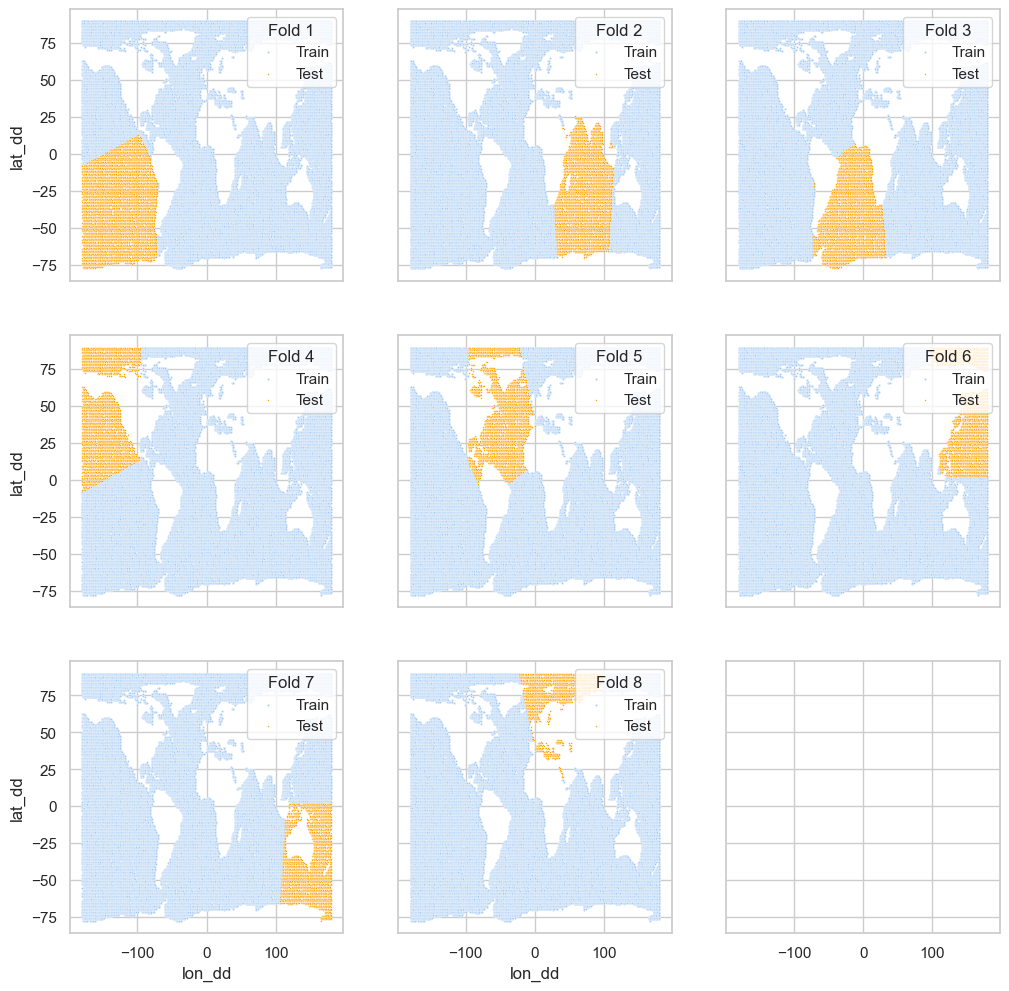

In [28]:
# Visualize cross-validation folds obtained from spatial blocking
scv = GroupKFold(n_splits=num_blocks)
nrows, ncols = int(np.ceil(num_blocks/3)), 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
for fold_num, ((idx_train, idx_test), ax) in enumerate(zip(scv.split(X_train, y_train, groups=blocks_train), axs.reshape(-1))):
    sns.scatterplot(data=train.iloc[idx_train].drop_duplicates(subset=geo_coords_name),
                    x='lon_dd', y='lat_dd', color='#a1c9f4', marker='.', s=10, label='Train', ax=ax);
    sns.scatterplot(data=train.iloc[idx_test].drop_duplicates(subset=geo_coords_name),
                    x='lon_dd', y='lat_dd', color='orange', marker='.', s=5, label='Test', ax=ax);
    ax.legend(title=f'Fold {fold_num + 1}');

In [29]:
# Construct ML pipeline including:
# - imputation of missing values
# - standardization
# - XGBoost model training
# - hyperparameter optimization with block k-fold cross-validation
preprocessor = make_pipeline(SimpleImputer(),
                             StandardScaler())
pipe = make_pipeline(preprocessor,
                     XGBRegressor(tree_method='hist', random_state=2023))
param_distribs = dict(
    pipeline__simpleimputer__strategy=['mean', 'median'],
    xgbregressor__max_depth=stats.randint(2, 20), # default=6
    xgbregressor__subsample=[0.5, 0.6, 0.7, 0.8, 0.9, 1], # default=1
    xgbregressor__colsample_bytree=[0.5, 0.6, 0.7, 0.8, 0.9, 1], # default=1
    xgbregressor__learning_rate=[0.05, 0.1, 0.15, 0.2, 0.3], # default=0.3
    xgbregressor__n_estimators=stats.randint(25, 500)) # default=100
rand_search = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_distribs,
                                 scoring='neg_mean_squared_error',
                                 cv=GroupKFold(n_splits=num_blocks),
                                 n_iter=500, n_jobs=-1,
                                 random_state=2023)
rand_search

RandomizedSearchCV(cv=GroupKFold(n_splits=8),
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('simpleimputer',
                                                               SimpleImputer()),
                                                              ('standardscaler',
                                                               StandardScaler())])),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_cate...
                                        'xgbregressor__learning_rate': [0.05,
                                                                        0.1,
                                                                        0.15,
                                                                        0.2,
                                                                        0.3],
                                        'xgbregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9e373baa40>,
                                        'xgbregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9e379df5b0>,
                                        'xgbregressor__subsample': [0.5, 0.6,
                                                                    0.7, 0.8,
                                                                    0.9, 1]},
                   random_state=2023, scoring='neg_mean_squared_error')

In [30]:
# Train model on training set
# and tune hyperparameters using cross-validated random search
rand_search.fit(X_train, y_train, groups=blocks_train)
print(f'Optimal hyperparameters: {rand_search.best_params_}')
print(f'Mean cross-validated MSE of optimized model is: {-rand_search.best_score_:.3f}')

/Users/ash/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal hyperparameters: {'pipeline__simpleimputer__strategy': 'median', 'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 19, 'xgbregressor__n_estimators': 75, 'xgbregressor__subsample': 0.6}
Mean cross-validated MSE of optimized model is: 0.035


In [31]:
# Evaluate performance of model with optimal hyperparameters on different folds of training data
fold_score_cols = ['split' + str(n_fold) + '_test_score' for n_fold in range(fold_num + 1)]
best_score_folds = -pd.DataFrame(rand_search.cv_results_).sort_values(
    by='rank_test_score', ascending=True).iloc[0:1, :][[*fold_score_cols, 'mean_test_score']].round(3)
best_score_folds_piv = best_score_folds.melt().rename(columns={'variable': 'Fold', 'value': 'Hold-out MSE'})
best_score_folds_piv['Fold'] = best_score_folds_piv['Fold'].str.split(pat='_', expand=True, regex=False)[0]
best_score_folds_piv

Fold  Hold-out MSE
0  split0         0.042
1  split1         0.026
2  split2         0.059
3  split3         0.056
4  split4         0.039
5  split5         0.021
6  split6         0.013
7  split7         0.025
8    mean         0.035

In [32]:
# Evaluate performance of trained, optimized model on test set
y_pred = rand_search.predict(X_test)
print(f'Test MSE is: {mean_squared_error(y_test, y_pred, squared=True):.3f}')
print(f'Test RMSE is: {mean_squared_error(y_test, y_pred, squared=False):.3f}')
print(f'Test MAE is: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'Test R^2 (proportion of explained variance) is: {r2_score(y_test, y_pred):.2f}')

Test MSE is: 0.003
Test RMSE is: 0.055
Test MAE is: 0.023
Test R^2 (proportion of explained variance) is: 0.99


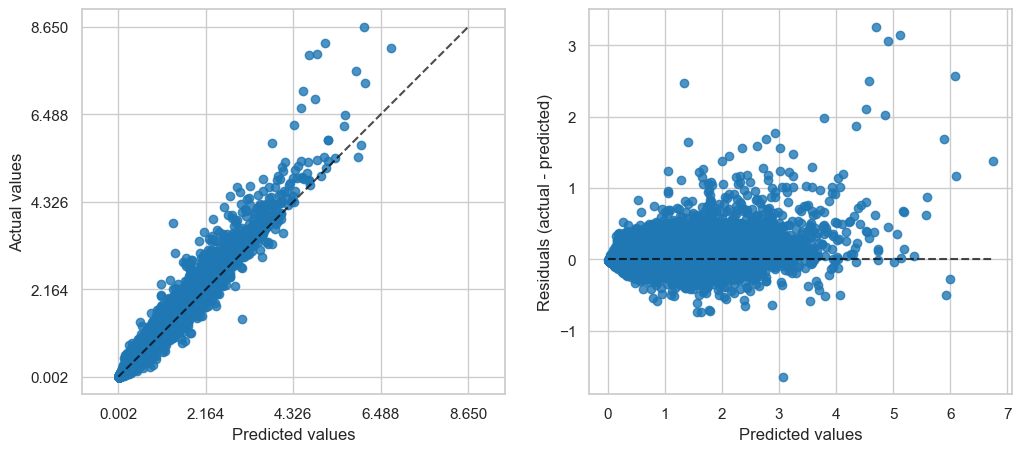

In [136]:
# Plot residuals vs. predicted values
# to check if residuals follow homoscedastic or heteroscedastic distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_pred, kind='actual_vs_predicted', subsample=None, ax=ax1);
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=y_pred, kind='residual_vs_predicted', subsample=None, ax=ax2);

In [137]:
test_df = test.copy()[[*geo_coords_name, dep_coord_name, 'dep_bins']]
test_df['y_true'] = y_test
test_df['y_hat'] = y_pred
test_df['residual'] = y_test - y_pred
test_df.head()

lat_dd  lon_dd    z_m     dep_bins    y_true     y_hat  residual
0   -76.5  -179.5  100.0  100 - 112.5  2.196537  2.098391  0.098146
1   -76.5  -179.5  125.0  112.5 - 125  1.669232  1.606813  0.062419
2   -76.5  -179.5  150.0    125 - 150  1.468749  1.430526  0.038222
3   -76.5  -179.5  200.0    150 - 200  1.201815  1.129961  0.071854
4   -76.5  -179.5  250.0    200 - 300  1.077668  1.088698 -0.011030

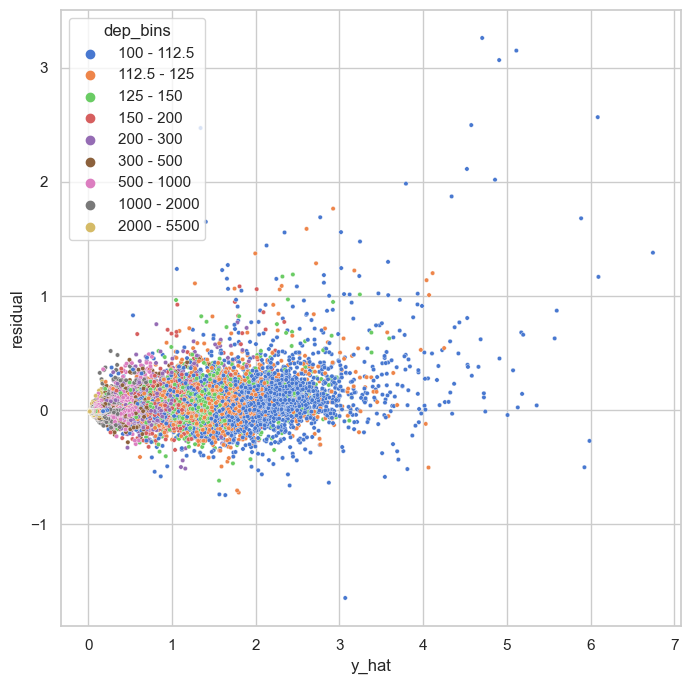

In [138]:
# Visualize residuals by binned depth
sns.scatterplot(data=test_df, x='y_hat', y='residual', hue='dep_bins', palette='muted', s=10);

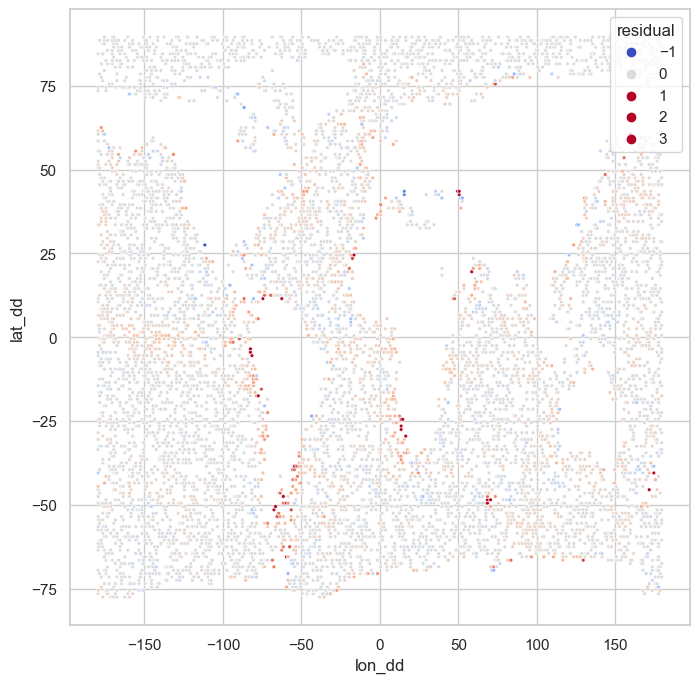

In [139]:
# Visualize geolocation of residuals in 100-125m depth bin (i.e., depth bin in which residuals are highest)
sns.scatterplot(data=test_df[(test_df['z_m'] == 100) | (test_df['z_m'] == 125)].groupby(
    geo_coords_name).mean(numeric_only=True).reset_index(drop=False),
                x='lon_dd', y='lat_dd', hue='residual',
                palette='coolwarm', hue_norm=(-1, 1),
                marker='.', s=30);

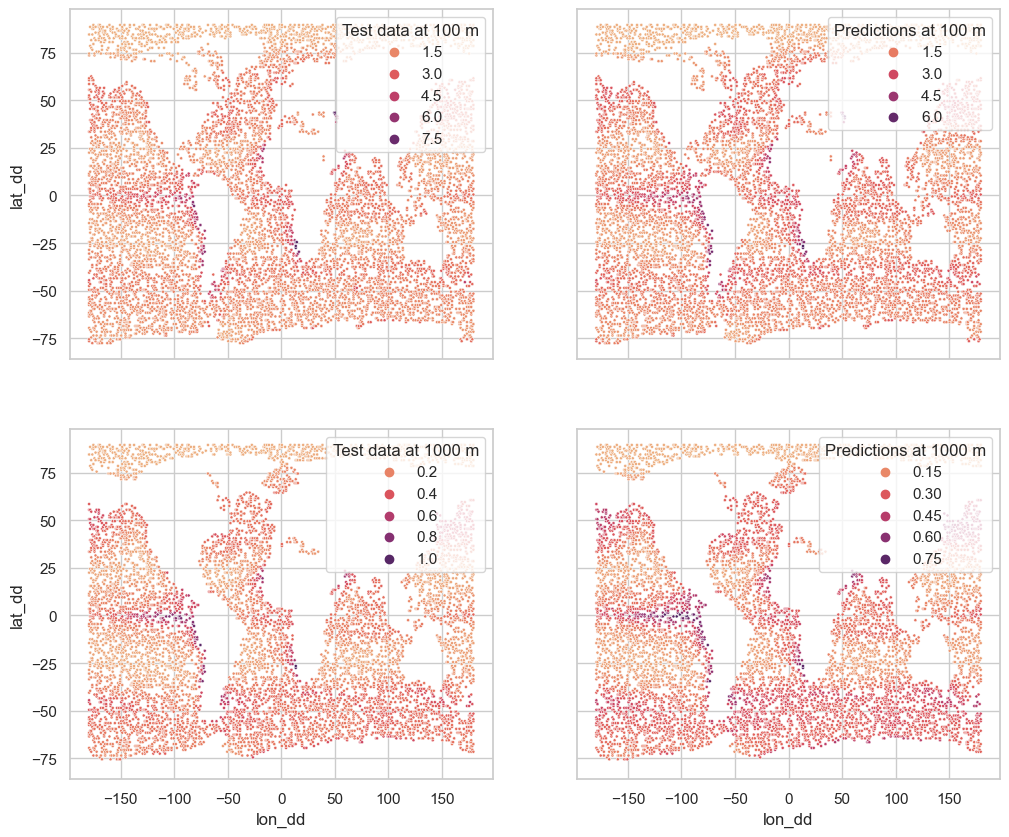

In [140]:
# Show maps of true vs. predicted values at depths of 100 and 1000 m
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 10))
sns.scatterplot(data=test_df[test_df['z_m'] == 100],
                x='lon_dd', y='lat_dd', hue='y_true', palette='flare', marker='.', s=20, ax=ax1);
ax1.legend(title='Test data at 100 m');
sns.scatterplot(data=test_df[test_df['z_m'] == 100],
                x='lon_dd', y='lat_dd', hue='y_hat', palette='flare', marker='.', s=20, ax=ax2);
ax2.legend(title='Predictions at 100 m');
sns.scatterplot(data=test_df[test_df['z_m'] == 1000],
                x='lon_dd', y='lat_dd', hue='y_true', palette='flare', marker='.', s=20, ax=ax3);
ax3.legend(title='Test data at 1000 m');
sns.scatterplot(data=test_df[test_df['z_m'] == 1000],
                x='lon_dd', y='lat_dd', hue='y_hat', palette='flare', marker='.', s=20, ax=ax4);
ax4.legend(title='Predictions at 1000 m');